In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Blood Vessels Segmentation

In [ ]:
# Convert RGB image to CMY and isolate magenta component
def rgb_to_cmy(image):
    return 1 - image / 255.0

def isolate_magenta(cmy_image):
    return cmy_image[:, :, 1]

# Apply morphological operations
def morphological_operations_vessels(image):
    kernel = np.ones((3, 3), np.uint8)
    eroded = cv2.erode(image, kernel, iterations=1)
    opened = cv2.morphologyEx(eroded, cv2.MORPH_OPEN, kernel)
    dilated = cv2.dilate(opened, kernel, iterations=1)
    return dilated

# Subtract morphological result from magenta component
def subtract_images(magenta, morphed):
    return cv2.subtract(magenta, morphed)

# Adaptive histogram equalization for contrast enhancement
def histogram_equalization(image):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(image)
    return equalized

# Binarize the image using global thresholding
def binarize_image(image):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    _, binary_image = cv2.threshold(image, 17, 255, cv2.THRESH_BINARY)
    return binary_image

# Reduce noise
def noise_reduction(binary_image):
    kernel = np.ones((1, 1), np.uint8)
    opened = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    num_labels, labels_im = cv2.connectedComponents(closed)

    for i in range(1, num_labels):
        if np.sum(labels_im == i) < 100:
            closed[labels_im == i] = 0

    return closed

# Compute blood vessel density
def compute_density(binary_image):
    white_pixels = np.sum(binary_image == 255)
    total_pixels = binary_image.size
    density = white_pixels / total_pixels
    return density

def segment_vessels(image):
    cmy_image = rgb_to_cmy(image)
    magenta_component = isolate_magenta(cmy_image)
    morphed_image = morphological_operations_vessels(magenta_component)
    subtracted_image = subtract_images(magenta_component, morphed_image)
    enhanced_image = histogram_equalization(subtracted_image)
    binary_image = binarize_image(enhanced_image)
    vessels = noise_reduction(binary_image)
    density = compute_density(vessels)
    return vessels, density

Optic Disc Segmentation

In [ ]:
def extract_red_channel(image):
    return image[:, :, 2]

def equalize_histogram(channel):
    if channel.dtype != np.uint8:
        channel = channel.astype(np.uint8)

    return cv2.equalizeHist(channel)

def calculate_histogram(channel):
    return cv2.calcHist([channel], [0], None, [256], [0, 256]).flatten()

def find_threshold(histogram, total_pixels, max_intensity):
    threshold_value = max_intensity - 1
    while threshold_value > 0:
        count_pixels = np.sum(histogram[threshold_value:])
        if count_pixels / total_pixels >= 0.025:
            break
        threshold_value -= 1
    return threshold_value

def apply_threshold(channel, threshold_value):
    _, binary_image = cv2.threshold(channel, threshold_value, 255, cv2.THRESH_BINARY)
    return binary_image

def morphological_closing(binary_image, kernel_size=(7, 7)):
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, structuring_element)
    return closed_image

def find_brightest_point(channel):
    _, _, _, max_loc = cv2.minMaxLoc(channel)
    return max_loc

def fit_ellipse_and_draw_contours(closed_image, brightest_point):
    contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    disc = np.zeros_like(closed_image)
    if contours:
        for contour in contours:
            distance = cv2.pointPolygonTest(contour, brightest_point, True)
            if distance >= 0:
                cv2.drawContours(disc, [contour], -1, (255, 255, 0), -1)
                break
        structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
        disc = cv2.morphologyEx(disc, cv2.MORPH_CLOSE, structuring_element)
    return disc

def segment_optic_disc(image):
    red_channel = extract_red_channel(image)
    equalized_red_channel = equalize_histogram(red_channel)
    histogram = calculate_histogram(equalized_red_channel)
    total_pixels = red_channel.size
    max_intensity = np.max(red_channel)
    threshold_value = find_threshold(histogram, total_pixels, max_intensity)
    binary_image = apply_threshold(equalized_red_channel, threshold_value)
    closed_image = morphological_closing(binary_image)
    brightest_point = find_brightest_point(red_channel)
    disc = fit_ellipse_and_draw_contours(closed_image, brightest_point)
    return disc

Fovea Elimination

In [ ]:
def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def apply_adaptive_histogram_equalization(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    # Ensure the image is grayscale and of type uint8
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

def apply_morphological_closing(image, kernel_size=(7, 7)):
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

def apply_thresholding(image):
    _, thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresholded_image

def remove_small_areas(image, min_area=25):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(image)
    for contour in contours:
        if cv2.contourArea(contour) > min_area:
            cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)
    return cv2.bitwise_and(image, mask)

def create_roi_mask(image_shape, center, width, height):
    mask = np.zeros(image_shape, dtype=np.uint8)
    x1 = max(center[0] - width // 2, 0)
    x2 = min(center[0] + width // 2, image_shape[1])
    y1 = max(center[1] - height // 2, 0)
    y2 = min(center[1] + height // 2, image_shape[0])
    mask[y1:y2, x1:x2] = 255
    return mask, (x1, y1), (x2, y2)

def segment_fovea(image):
    # Preprocess the image
    grayscale_image = convert_to_grayscale(image)
    enhanced_image = apply_adaptive_histogram_equalization(grayscale_image)
    closed_image = apply_morphological_closing(enhanced_image)
    thresholded_image = apply_thresholding(closed_image)
    final_image_fovea = remove_small_areas(thresholded_image)

    # Define the ROI
    image_center = (grayscale_image.shape[1] // 2, grayscale_image.shape[0] // 2)
    roi_width = 160
    roi_height = 100
    fovea, roi_start, roi_end = create_roi_mask(grayscale_image.shape, image_center, roi_width, roi_height)
    return fovea

Microaneurysms Detection

In [ ]:
def split_channels(image):
    return cv2.split(image)

def apply_clahe(channel, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(channel)

def threshold_image(image, thresh_value=30):
    _, binary = cv2.threshold(image, thresh_value, 255, cv2.THRESH_BINARY_INV)
    return binary

def subtract_images(image1, image2):
    return cv2.subtract(image1, image2)

def remove_fovea_region(image, fovea_mask):
    result = image.copy()
    result[fovea_mask == 255] = 0
    return result

def apply_dilation(image, kernel_size=(3, 3), iterations=2):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    return cv2.dilate(image, kernel, iterations=iterations)

def filter_small_components(image, max_size=33):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(image, connectivity=4)
    sizes = stats[:, -1]
    result_image = np.zeros_like(image)
    for i in range(1, num_labels):
        if sizes[i] < max_size:
            result_image[labels == i] = 255
    no_of_ma = num_labels - 1
    return result_image, no_of_ma

def detect_microaneurysms(image, blood_vessels_image, fovea):
    R, G, B = split_channels(image)
    enhanced = apply_clahe(G)
    binary = threshold_image(enhanced)
    difference = subtract_images(binary, blood_vessels_image)
    improved_image = remove_fovea_region(difference, fovea)
    dilated_image = apply_dilation(improved_image)
    microaneurysms, no_of_ma = filter_small_components(dilated_image)
    ma_area = np.sum(microaneurysms == 255)
    return np.array([no_of_ma, ma_area])

Hemorrhages Detection

In [ ]:
def apply_clahe(channel, clip_limit=2.0, tile_grid_size=(8, 8)):
    if channel.dtype != np.uint8:
        channel = channel.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(channel)

def threshold_image(image, thresh_value=48):
    _, binary = cv2.threshold(image, thresh_value, 255, cv2.THRESH_BINARY_INV)
    return binary

def subtract_images(image1, image2):
    return cv2.subtract(image1, image2)

def remove_fovea_region(image, fovea_mask):
    result = image.copy()
    result[fovea_mask == 255] = 0
    return result

def filter_components(image):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[:, -1]
    result = np.zeros_like(image)
    for i in range(1, num_labels):
        if sizes[i] < 1000:
            result[labels == i] = 255

    no_of_hmr = num_labels - 1
    return result, no_of_hmr

def detect_hemorrhages(image, blood_vessels, fovea):
    R, G, B = cv2.split(image)
    enhanced = apply_clahe(G)
    binary = threshold_image(enhanced)
    # Subtract blood vessels
    difference = subtract_images(binary, blood_vessels)
    # Remove fovea region
    improved_image = remove_fovea_region(difference, fovea)
    hemorrhages, no_of_hmr = filter_components(improved_image)
    hmr_area = np.sum(hemorrhages == 255)
    return np.array([no_of_hmr, hmr_area])


Exudates Detection

In [ ]:
def rgb_to_cmy(image):
    return 1 - image / 255.0

def extract_magenta_component(cmy_image):
    return cmy_image[:, :, 1]

# Threshold-based binarization with an adjusted threshold
def threshold_binarization(magenta_component):
    std_dev = np.std(magenta_component)
    threshold = std_dev * 3.8
    _, binary_image = cv2.threshold(magenta_component, threshold, 1, cv2.THRESH_BINARY_INV)
    return binary_image

def improve_binary_image(binary_image, optic_disc):
    improved_image = binary_image.copy()
    improved_image[optic_disc == 255] = 0  # Masking out optic-disc
    return improved_image

def dilate_image(binary_image):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    dilated_image = cv2.dilate(binary_image, kernel, iterations=1)
    return dilated_image

def remove_large_regions(dilated_image):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(dilated_image.astype(np.uint8), connectivity=4)
    sizes = stats[:, -1]
    result_image = np.zeros_like(dilated_image)
    for i in range(1, num_labels):
        if sizes[i] < 1000:
            result_image[labels == i] = 1
    return result_image

def erode_image(binary_image):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    eroded_image = cv2.erode(binary_image, kernel, iterations=1)
    return eroded_image

# Function to compute the density of exudates
def compute_density(binary_image):
    white_pixels = np.sum(binary_image == 1)
    total_pixels = binary_image.size
    density = white_pixels / total_pixels
    return density

def detect_exudates(image, optic_disc):
    cmy_image = rgb_to_cmy(image)
    magenta_component = extract_magenta_component(cmy_image)
    binary_image = threshold_binarization(magenta_component)
    improved_image = improve_binary_image(binary_image, optic_disc)
    dilated_image = dilate_image(improved_image)
    cleaned_image = remove_large_regions(dilated_image)
    exudates = erode_image(cleaned_image)
    exudates_density = compute_density(exudates)
    return np.array([exudates_density])

Neovascularization

In [ ]:
def rgb_to_magenta(image):
    cmy_image = 1 - image / 255.0
    magenta_image = cmy_image[:, :, 1]
    return magenta_image

def morphological_vessels(image):
    kernel = np.ones((3, 3), np.uint8)
    eroded = cv2.erode(image, kernel, iterations=1)
    opened = cv2.morphologyEx(eroded, cv2.MORPH_OPEN, kernel)
    dilated = cv2.dilate(opened, kernel, iterations=1)
    return dilated

def subtract_images(original, morphed):
    return cv2.subtract(original, morphed)

def histogram_equalization(image):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(image)
    return equalized

def binarize_image(image):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    _, binary_image = cv2.threshold(image, 17, 255, cv2.THRESH_BINARY)
    return binary_image

def noise_reduct(binary_image):
    kernel = np.ones((1, 1), np.uint8)
    opened = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    num_labels, labels_im = cv2.connectedComponents(closed)

    for i in range(1, num_labels):
        if np.sum(labels_im == i) < 100:
            closed[labels_im == i] = 0

    return closed

def skeletonize(image):
    return cv2.ximgproc.thinning(image)

def analyze_tortuosity_lenght(skeleton):
    # Identify individual vessel segments
    num_labels, labels_im = cv2.connectedComponents(skeleton)

    abnormal_vessels = np.zeros_like(skeleton)

    # Analyze each vessel segment
    for i in range(1, num_labels):
        segment = np.zeros_like(skeleton)
        segment[labels_im == i] = 255

        # Measure the length of the segment
        length = np.sum(segment > 0)

        # Measure the tortuosity (sum of angles between successive pixels)
        coords = np.column_stack(np.where(segment > 0))
        if len(coords) < 5:
            continue

        total_angle = 0
        for j in range(1, len(coords) - 1):
            p1 = coords[j - 1]
            p2 = coords[j]
            p3 = coords[j + 1]
            v1 = p2 - p1
            v2 = p3 - p2
            angle = np.arctan2(np.linalg.det([v1, v2]), np.dot(v1, v2))
            total_angle += np.abs(angle)

        tortuosity = total_angle / length

        # High tortuosity and shorter length indicates new abnormal vessels
        if tortuosity > 0.7 and length < 120:
            abnormal_vessels[labels_im == i] = 255

    return abnormal_vessels

def compute_density(image):
    white_pixels = np.sum(image == 255)
    total_pixels = image.size
    density = white_pixels / total_pixels
    return density

def detect_neovascularization(image):
    magenta_component = rgb_to_magenta(image)
    morphed_image = morphological_vessels(magenta_component)
    subtracted_image = subtract_images(magenta_component, morphed_image)
    enhanced_image = histogram_equalization(subtracted_image)
    binary_image = binarize_image(enhanced_image)
    vessels = noise_reduct(binary_image)
    skeleton = skeletonize(vessels)
    abnormal_vessels = analyze_tortuosity_lenght(skeleton)
    abnormal_vessel_density = compute_density(abnormal_vessels)
    return np.array([abnormal_vessel_density])

In [ ]:
def std_rgb(image):
    b, g, r = cv2.split(image)
    std_r = np.std(r)
    std_g = np.std(g)
    std_b = np.std(b)
    return np.array([std_r, std_g, std_b])

In [ ]:
def compute_entropy_g(image):
    b, g, r = cv2.split(image)
    # Compute the histogram
    histogram, _ = np.histogram(g.flatten(), bins=256, range=[0,256])

    # Normalize the histogram to get the probability distribution
    probability_distribution = histogram / histogram.sum()

    # Compute the entropy
    entropy_g = -np.sum(probability_distribution * np.log2(probability_distribution + 1e-10))

    return np.array([entropy_g])

In [ ]:
from skimage import color
from skimage.feature import graycomatrix, graycoprops

def compute_texture_features(image):
    gray_image = color.rgb2gray(image)

    # Compute the GLCM (Gray-Level Co-occurrence Matrix)
    glcm = graycomatrix((gray_image * 255).astype(np.uint8), [1], [0], symmetric=True, normed=True)

    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    entropy = -np.sum(energy * np.log2(energy + 1e-10))
    return np.array([homogeneity, contrast, energy, entropy])

In [ ]:
def calculate_features(candidate_segment):
    # Convert candidate segment to float
    candidate_segment = candidate_segment.astype(float)

    # Energy
    energy = np.sum(candidate_segment ** 2)

    # Gradient calculation
    gradient_x = cv2.Sobel(candidate_segment, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(candidate_segment, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)

    # Mean Gradient
    mean_gradient = np.mean(gradient_magnitude)

    # Standard Deviation Gradient
    std_gradient = np.std(gradient_magnitude)

    # Mean Intensity
    mean_intensity = np.mean(candidate_segment)

    # Intensity Variation
    std_intensity = np.std(candidate_segment)
    intensity_variation = mean_intensity / (std_intensity + 1e-10)

    return np.array([energy, mean_gradient, std_gradient, mean_intensity, intensity_variation])

In [ ]:
def resize_image(image, size=(512, 512)):
    return cv2.resize(image, size)

In [ ]:
def extract_features(image):
    image = resize_image(image)
    vessels, vessel_density = segment_vessels(image)
    optic_disc = segment_optic_disc(image)
    fovea = segment_fovea(image)
    vessels_feature = np.array([vessel_density])
    microaneurysms_features = detect_microaneurysms(image, vessels, fovea)
    hemorrhages_features = detect_hemorrhages(image, vessels, fovea)
    exudates_features = detect_exudates(image, optic_disc)
    neovascularization_features = detect_neovascularization(image)
    rgb_std_features = std_rgb(image)
    entropy_g_feature = compute_entropy_g(image)
    texture_features = compute_texture_features(image)
    nv_features = calculate_features(vessels)

    # Combine all features into a single feature vector
    features = np.concatenate([
        vessels_feature,
        microaneurysms_features,
        hemorrhages_features,
        exudates_features,
        neovascularization_features,
        rgb_std_features,
        entropy_g_feature,
        texture_features,
        nv_features])
    return features

In [ ]:
def load_images_and_labels_from_folder(dataset_folder):
    images = []
    labels = []
    for label in os.listdir(dataset_folder):
        label_folder = os.path.join(dataset_folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

# Load dataset
dataset_folder = '/content/drive/MyDrive/Datasets/DR5'
X, y = load_images_and_labels_from_folder(dataset_folder)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
from joblib import dump,load

In [ ]:
features_path = '/content/drive/MyDrive/features-aug2.joblib'

In [ ]:
# Preprocess and extract features
X_features = np.array([extract_features(image) for image in X])
dump(X_features, features_path)

['/content/drive/MyDrive/features-aug2.joblib']

In [ ]:
loaded_features = load(features_path)

In [ ]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(loaded_features, y_encoded, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
model_path = '/content/drive/MyDrive/model-rf5.joblib'

In [ ]:
dump(rf_classifier, model_path)

['/content/drive/MyDrive/model-rf5.joblib']

In [ ]:
loaded_model = load(model_path)

In [ ]:
import cv2
import os
import numpy as np

def predict_image_from_name(image_path, model, label_encoder):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")

    # Extract features from the image
    features = extract_features(img)
    features = features.reshape(1, -1)

    # Make prediction
    prediction = model.predict(features)

    # Decode the label
    predicted_label = label_encoder.inverse_transform(prediction)

    return predicted_label[0]

dataset_folder2 = '/content/drive/MyDrive/Datasets/DR2/images'

# filename = '20051020_43808_0100_PP.png'   #0-None
# filename = '20051020_56592_0100_PP.png'   #1-Mild
# filename = '20051020_44901_0100_PP.png'   #2-Moderate
filename = '20051020_57761_0100_PP.png'   #3-Severe
# filename = '20051020_45110_0100_PP.png'   #4-PDR

image_path = os.path.join(dataset_folder2, filename)

predicted_label = predict_image_from_name(image_path, loaded_model, label_encoder)
print(f'Predicted subtype: {predicted_label}')


Predicted subtype: 3-Severe


**-------------------------------------------------------------------------------------------------**

In [ ]:
y_pred_rf = loaded_model_new.predict(X_test)

# Evaluate Random Forest model
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Accuracy: 0.7714285714285715
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       115
           1       0.83      0.59      0.69        68
           2       0.85      0.65      0.73        62
           3       0.59      0.74      0.66        85
           4       0.68      0.78      0.73        55

    accuracy                           0.77       385
   macro avg       0.78      0.74      0.75       385
weighted avg       0.79      0.77      0.77       385

Random Forest Confusion Matrix:
 [[111   3   1   0   0]
 [  2  40   0  24   2]
 [  2   2  40  11   7]
 [  4   2   5  63  11]
 [  2   1   1   8  43]]


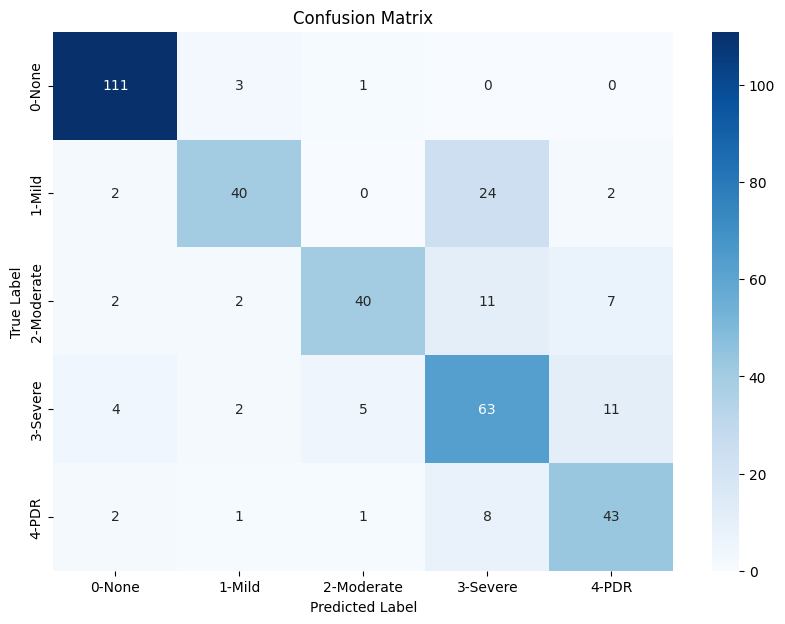

In [ ]:
# Create a heatmap for the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()